<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Jose Leonardo Aceves Gonzalez y María Fernanda Amador Alvarez.

**Fecha:** 27 de noviembre del 2021.

**Expediente** : 712626 y 725573.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/feramdor/Tarea9-10_Amdor_Aceves
# Tarea 10: Clase 24

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

### Estudiante 1: Fernanda Amador

In [1]:
# Librerías
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

#Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

# Opción Call

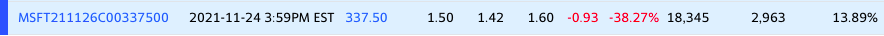

In [3]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_micro = closes.loc[:,'MSFT']
closes_micro.head(5)

Date
2017-01-03    58.186
2017-01-04    57.925
2017-01-05    57.925
2017-01-06    58.427
2017-01-09    58.241
Name: MSFT, dtype: float64

In [4]:
ret_micro = calc_daily_ret(closes_micro)
mu = ret_micro.mean()
sigma = ret_micro.std()
r = (0.006/360)
mu,sigma,r

(0.001405580121364679, 0.017335181700385845, 1.6666666666666667e-05)

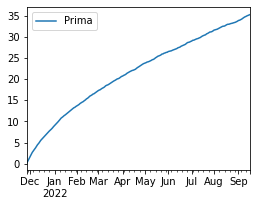

In [5]:
# Datos de la opción y del día de actual
from datetime import date
today = pd.Timestamp(date.today())
expiry = '2022-09-16'
# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, 
                      end = expiry, 
                      freq = 'B')
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000
K = 337.5
S0 = closes_micro.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

#____Valuación de la opción baśandonos en la función de pago correspondiente (Europea)____:
strike = K
call_=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike,0).mean(axis=1)},index=dates)
call_.plot(figsize=(4,3));

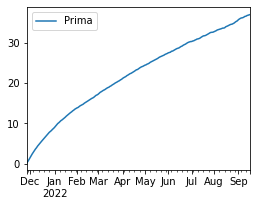

In [8]:
# Histograma 

# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_micro-mu+r, bins=10000)

prob = freq/np.sum(freq)

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-09-16'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, 
                      end = expiry,
                      freq = 'B')

# Cantidad de escenarios a simular para el método de Montecarlo
ndays = len(dates)
nscen = 10000
K = 337.5
S0 = closes_micro.iloc[-1]
ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret, index = dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index = dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot(figsize = (4,3));

In [9]:
pd.set_option('display.max_columns', 15)
# Precio barrera
B = 280
# Función de desactivación (knock-out) DOWN AND OUT
# Si en algún momento el precio toca la barrera la opción se desactiva
I =(sim_closes > B).cumprod(axis=0)  > 0
I.head(3)

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-11-26,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-11-29,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-11-30,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True


In [10]:
K, S0

(337.5, 329.67999267578125)

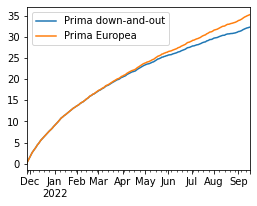

In [11]:
#gráfico:
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot(figsize=(4,3));
call.plot(ax=ax);

# Opción Put

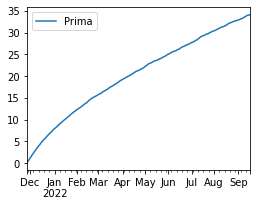

In [12]:
# Datos de la opción y del día de actual
from datetime import date
today = pd.Timestamp(date.today())
expiry = '2022-09-16'
# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, 
                      end = expiry, 
                      freq = 'B')
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000
K = 340
S0 = closes_micro.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

#____Valuación de la opción baśandonos en la función de pago correspondiente (Europea):
strike = K
put_=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike,0).mean(axis = 1)},index = dates)
put_.plot(figsize = (4,3));

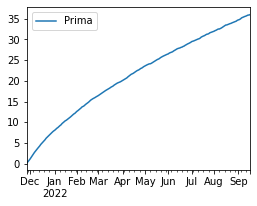

In [13]:
# Histograma
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_micro-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)
#
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-09-16'
# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, 
                      end = expiry, 
                      freq = 'B')
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000
K = 340
S0 = closes_micro.iloc[-1]
ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret, index = dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
#
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index = dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot(figsize =(4,3));

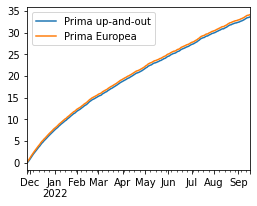

In [26]:
# Definir barrera
B = 338
# Crear función indicador
I = (sim_closes < B).cumsum(axis = 0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis = 1)},index = dates)
# Calcular la prima de una opción barrera
put_ = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis = 1)},index = dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = put_.plot(figsize=(4,3));
put.plot(ax=ax);

In [27]:
call.iloc[-1],callui.iloc[-1]

(Prima Europea    35.262
 Name: 2022-09-16 00:00:00, dtype: float64,
 Prima down-and-out    32.295
 Name: 2022-09-16 00:00:00, dtype: float64)

In [28]:
put.iloc[-1],put_.iloc[-1]

(Prima Europea    34.144
 Name: 2022-09-16 00:00:00, dtype: float64,
 Prima up-and-out    33.618
 Name: 2022-09-16 00:00:00, dtype: float64)

### Conclusión
La barrera hace que disminuya el precio de la prima

### Estudiante 2: Leonardo Aceves